# Determining constants for the Leishman-Beddoes dynamic stall model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, cos, exp, pi, log, sqrt
import pandas as pd
import seaborn

In [2]:
# Function for loading data
def load(foil="NACA0021"):
    alpha = []
    cl = []
    cd = []
    with open("data/{}.dat".format(foil)) as f:
        for line in f.readlines():
            if line.strip()[:2] == "//":
                pass
            else:
                line = line.replace("(", "")
                line = line.replace(")", "")
                line = line.split()
                alpha.append(float(line[0]))
                cl.append(float(line[1]))
                cd.append(float(line[2]))
    df = pd.DataFrame()
    df["alpha_deg"] = np.asarray(alpha)
    df["alpha_rad"] = df.alpha_deg/180.0*np.pi
    df["cl"] = np.asarray(cl)
    df["cd"] = np.asarray(cd)
    df["cn"] = df.cl*np.cos(df.alpha_rad) - df.cd*np.sin(df.alpha_rad)
    df["ct"] = df.cl*np.sin(df.alpha_rad) - df.cd*np.cos(df.alpha_rad)
    return df

Next we want to find the constants $S_1$ and $S_2$ that relate the Kirchhoff separation point to the normal force coefficient.

$$
C_N = C_{N_\alpha} \left( \frac{1 + \sqrt{f}}{2} \right)^2 \alpha
$$

Rearranging we have

$$
f = \left(2\sqrt{\frac{C_N}{\alpha C_{N_\alpha}}} - 1\right)^2
$$

The separation point is then

$$
f = 1 - 0.3 \exp \left[ (\alpha - \alpha_1)/S_1 \right]
$$

for $\alpha \leq \alpha_1$, and for $\alpha > \alpha1$

$$
f = 0.04 - 0.66 \exp \left[ (\alpha_1 - \alpha)/S_2 \right].
$$

We will use formulas for an exponential curve fit of the form

$$
y = A \mathrm{e}^{Bx},
$$

which gives 

In [3]:
"""
Least squares fitting for finding s1 and s2
Kept as close to the C++ code as possible to return back

Constants from f equation
    f = A - B*exp ...
    f = C + D exp ...
"""

def calc_s1_s2(df, alpha1, cn_alpha, A=1, B=0.3, C=0.04, D=0.66):
    sumY = 0.0
    sumXYLnY = 0.0
    sumXY = 0.0
    sumYLnY = 0.0
    sumX2Y = 0.0
    alphaLowerLimit = 0.0
    alphaUpperLimit = alpha1

    #Translational stuff
    alphaDegList = df.alpha_deg.values
    clList = df.cl.values
    cdList = df.cd.values
    CNAlpha = cn_alpha
    mag = abs
    
    # Calculate S1
    for i in range(len(alphaDegList)):
        alphaRad = alphaDegList[i]/180.0*pi
        cn = clList[i]*cos(alphaRad) - cdList[i]*sin(alphaRad)
        if (alphaRad > alphaLowerLimit and alphaRad < alphaUpperLimit):
            f = pow((sqrt(abs(cn)/CNAlpha/abs(alphaRad))*2.0 - 1.0), 2)
            x = abs(alphaRad) - alpha1
            y = (f - A)/(-B)
            if (f > 0 and f < 1 and y > 0):
                sumY += y
                sumXYLnY += x*y*log(y)
                sumXY += x*y
                sumYLnY += y*log(y)
                sumX2Y += x*x*y

    b = (sumY*sumXYLnY - sumXY*sumYLnY)/(sumY*sumX2Y - sumXY*sumXY)
    S1 = 1.0/b

    # Calculate S2
    sumY = 0.0
    sumXYLnY = 0.0
    sumXY = 0.0
    sumYLnY = 0.0
    sumX2Y = 0.0
    alphaLowerLimit = alpha1 - 1e-3
    alphaUpperLimit = pi/6.0
    for i in range(len(alphaDegList)):
        alphaRad = alphaDegList[i]/180.0*pi
        cn = clList[i]*cos(alphaRad) - cdList[i]*sin(alphaRad)
        if (alphaRad > alphaLowerLimit and alphaRad < alphaUpperLimit):
            f = pow((sqrt(mag(cn)/CNAlpha/mag(alphaRad))*2.0 - 1.0), 2)
            x = alpha1 - abs(alphaRad);
            y = (f - C)/D;
            if (f > 0 and f < 1 and y > 0):
                sumY += y
                sumXYLnY += x*y*log(y)
                sumXY += x*y
                sumYLnY += y*log(y)
                sumX2Y += x*x*y
    b = (sumY*sumXYLnY - sumXY*sumYLnY)/(sumY*sumX2Y - sumXY*sumXY)
    S2 = 1.0/b
    
    return S1, S2

alpha_ss = 17.0
cn_alpha = 6.043
S1 = 0.023
S2 = 0.028


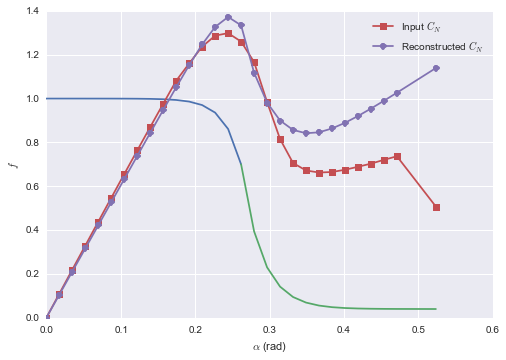

In [61]:
df = load("NACA0012")
frac_cn_alpha = 0.7 # Fraction of static stall angle to look for cn slope
frac_alpha1 = 0.9 # Fraction of static stall angle to define alpha1

# Find static stall angle
d_cd_d_alpha = np.diff(df.cd)/np.diff(df.alpha_deg)
n = np.where(d_cd_d_alpha > 0.02)[0]
alpha_ss = df.alpha_deg[n]
alpha_ss = alpha_ss[alpha_ss > 0].iloc[0]
print("alpha_ss = {:.1f}".format(alpha_ss))

# Calculate normal force slope
alpha1 = np.floor(alpha_ss*frac_cn_alpha)
alpha0 = np.floor(alpha_ss*0.0)
dalpha = alpha1 - alpha0
cn_alpha = (df.cn[df.alpha_deg==alpha1].iloc[0] \
            - df.cn[df.alpha_deg==alpha0].iloc[0])/(dalpha/180.0*np.pi)
print("cn_alpha = {:.3f}".format(cn_alpha))

# Find critical normal force coefficient
A, B, C, D = 1.0, 0.3, 0.04, 0.66 # Original model
# A, B, C, D = 1.0, 0.4, 0.02, 0.58 # 3G model
fcrit = A - B
alpha1 = (np.floor(alpha_ss*frac_alpha1))/180.0*np.pi
cn1 = cn_alpha*alpha1*((1 + np.sqrt(fcrit))/2.0)**2

# Put in some values for s1 and s2 (from turbinesFoam)
s1 = 0.109504058813
s2 = 0.0355536753234
s1, s2 = calc_s1_s2(df, alpha1, cn_alpha, A, B, C, D)
print("S1 = {:.3f}".format(s1))
print("S2 = {:.3f}".format(s2))

ind = np.logical_and(df.alpha_deg >=0, df.alpha_deg <= 30)
alpha = df.alpha_rad[ind]
alpha_low = alpha[alpha <= alpha1]
alpha_high = alpha[alpha >= alpha1]
f_low = 1.0 - 0.3*np.exp((alpha_low - alpha1)/s1)
f_high = 0.04 + 0.66*np.exp((alpha1 - alpha_high)/s2)

# Reconstruct normal force from f
cn_low = cn_alpha*alpha_low*((1 + np.sqrt(f_low))/2)**2
cn_high = cn_alpha*alpha_high*((1 + np.sqrt(f_high))/2)**2
cn = np.hstack((cn_low, cn_high[1:]))

plt.plot(alpha_low, f_low)
plt.plot(alpha_high, f_high)
plt.plot(alpha, df.cn[ind], "-s", label=r"Input $C_N$")
plt.plot(alpha, cn, "-o", label=r"Reconstructed $C_N$")
plt.xlabel(r"$\alpha$ (rad)")
plt.ylabel("$f$")
plt.legend(loc="best")
plt.savefig("figures/f.pdf")
plt.show()